$s$

In [1]:
import ipywidgets as widgets
out = widgets.Output()
with out:
    
    %bookmark 'model_dir'
    current_dir = %pwd
    while 'models' in current_dir:
        %cd ..
        current_dir = %pwd
    %bookmark 'base_dir'
    %cd source_code
    out.clear_output()
%run base
%run gui_v6
with out:
    %cd ..
    %cd models/fourbar
    out.clear_output()


In [2]:
m=model()
m.show()

## VEHICLE DYNAMICS MODELING AND SIMULATION TOOL

In [6]:
m.simulations=pd.Series()

In [19]:
m.model_tree()

In [4]:
m.actuators

mcs_rot    <constraints.rotational_actuator object at 0x0...
dtype: object

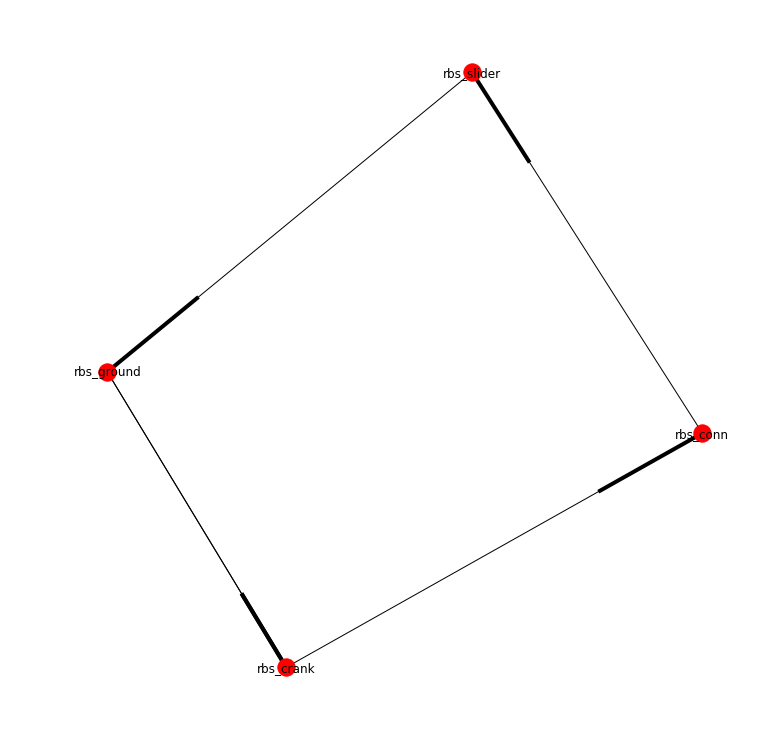

In [3]:
m.draw_topology()

In [16]:
m.topology.remove_edge(m.joints['jcs_rev'].i_body,m.joints['jcs_rev'].j_body,0)

KeyError: 'jcs_rev'

In [5]:
m.actuators

mcs_rot    <constraints.rotational_actuator object at 0x0...
dtype: object

In [14]:

m.topology.edges

OutMultiEdgeView([(rbs_ground, rbs_slider, 0), (rbs_ground, rbs_link, 0), (rbs_slider, rbs_ground, 0), (rbs_link, rbs_conn, 0), (rbs_conn, rbs_slider, 0)])

In [158]:
m.topology.nodes

NodeView((rbs_ground, rbs_crank, rbs_conn, rbs_slider))

In [182]:
import numpy as np
import scipy as sc

def equations_assembler(topology):
    
    edgelist = topology.edges(data='obj')
    nodelist = topology.nodes
    
    n_nodes = len(nodelist)
    n_edges = len(edgelist)
            
    jacobian = np.zeros((n_edges+n_nodes,n_nodes),dtype=np.object)
    jacobian.fill(None)
    
    equations = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    vel_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    acc_rhs = np.zeros((n_edges+n_nodes,1),dtype=np.object)
    
    node_index = dict( (node,i) for i,node in enumerate(nodelist) )
    
    n7 = np.arange(7)
    for ei,e in enumerate(edgelist):
        (u,v) = e[:2]
        eo    = e[2]
        
        ui = node_index[u]
        vi = node_index[v]
        
        if jacobian[ui+n_edges,ui]==None: jacobian[ui+n_edges,ui] = (u.jac,(ui*7)+n7)
        if jacobian[vi+n_edges,vi]==None: jacobian[vi+n_edges,vi] = (v.jac,(vi*7)+n7)
                
        jacobian[ei,ui] = (eo.jacobian_i,(ui*7)+n7,(vi*7)+n7)
        jacobian[ei,vi] = (eo.jacobian_j,(ui*7)+n7,(vi*7)+n7)
        
        equations[ei,0] = (eo.equations,(ui*7)+n7,(vi*7)+n7)
        if equations[ui+n_edges,0]==0: equations[ui+n_edges,0]=(u.equations,(ui*7)+n7)
        if equations[vi+n_edges,0]==0: equations[vi+n_edges,0]=(v.equations,(vi*7)+n7)
        
        
        vel_rhs[ei,0] = ((eo.vel_rhs) if eo.nc==1 else np.zeros((eo.nc,1)))
        vel_rhs[ui+n_edges,0] = (np.array([[0]]) if u.nc==1 else np.zeros((7,1)))
        vel_rhs[vi+n_edges,0] = (np.array([[0]]) if v.nc==1 else np.zeros((7,1)))
        
        acc_rhs[ei,0] = (eo.acc_rhs,(ui*7)+n7,(vi*7)+n7)
        if acc_rhs[ui+n_edges,0]==0: acc_rhs[ui+n_edges,0]=(u.acc_rhs,(ui*7)+n7)
        if acc_rhs[vi+n_edges,0]==0: acc_rhs[vi+n_edges,0]=(v.acc_rhs,(vi*7)+n7)
        
      
    def j_mapper(i,q):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj])
        else:
            fun,bi = i
            return fun(q[bi])
        
    j_vectorized = np.vectorize(j_mapper,otypes=[np.object],excluded='q')
    
    
    def v_mapper(i):
        if isinstance(i,(int,np.ndarray)):
            return i
        else:
            return i()

    v_vectorized = np.vectorize(v_mapper,otypes=[np.object])
    
    def a_mapper(i,q,qd):
        if len(i)==3:
            fun,bi,bj = i
            return fun(q[bi],q[bj],qd[bi],qd[bj])
        else:
            fun,bi = i
            return fun(qd[bi])

    a_vectorized = np.vectorize(a_mapper,otypes=[np.object],excluded=('q','qd'))
    
    return jacobian, equations, vel_rhs, acc_rhs, jacobian.nonzero(), j_vectorized, v_vectorized, a_vectorized


def jacobian_evaluator(jac_blocks,nzi,mapper,q):
    A = jac_blocks.copy()
    A[nzi]=mapper(A[nzi],q=q)
    return sc.sparse.bmat(A,format='csc')


In [168]:
def nr_kds(jac_blocks,equations_blocks,nzi,j_vectorized,guess):
    
    A = jacobian_evaluator(jac_blocks,nzi,j_vectorized,guess)
    
    b = equations_blocks.copy()
    b = np.concatenate(j_vectorized(e[e.nonzero()],q=guess))
    delta_q = sc.sparse.linalg.spsolve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        guess=guess+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(jac_blocks,nzi,j_vectorized,guess)
        b = np.concatenate(j_vectorized(e[e.nonzero()],q=guess))
        delta_q = sc.sparse.linalg.spsolve(A,-b)
        
        itr+=1
        
        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return guess,A


def kds(topology,actuators,time_array):
    q0 = pd.concat([i.q0 for i in topology.nodes])
    dt = time_array[1]-time_array[0]
    
    j,e,v,a,nzi,j_m, v_m, a_m = equations_assembler(topology)
    
    position_df=pd.DataFrame(columns=q0.index)
    position_df.loc[0]=q0
    
    A = jacobian_evaluator(j,nzi,j_m,q0.values)
     
    velocity_df=pd.DataFrame(columns=q0.index)
    velocity_df.loc[0] = v0 = sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        
    acceleration_df=pd.DataFrame(columns=q0.index)
    acceleration_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=q0.values,qd=v0)[:,0]))
    
    
    print('\nRunning System Kinematic Analysis:')
    for i,step in enumerate(time_array):
        
        for ac in actuators:
            ac.t=step
        
        g=position_df.loc[i]+velocity_df.loc[i]*dt + 0.5*acceleration_df.loc[i]*dt**2
         
        position_df.loc[i+1],A = nr_kds(j,e,nzi,j_m,g.values)
        qi=position_df.loc[i+1].values
        
        velocity_df.loc[i+1] = vi = sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        
        acceleration_df.loc[i+1]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=qi,qd=vi)[:,0]))
          
        i+=1
        
    return position_df, velocity_df, acceleration_df
    

def nr_kds(j,e,nzi,mapper,q):
    
    A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
    
    b = e.copy()
    b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
    delta_q = sc.sparse.linalg.spsolve(A,-b)
    
    itr=0
    while np.linalg.norm(delta_q)>1e-5:
        
        q=q+delta_q
        
        if itr!=0 and itr%5==0:
            print('Recalculating Jacobian')
            A = jacobian_evaluator(j,nzi,mapper,q.values.reshape((4,7)))
        b = np.concatenate(mapper(e[e.nonzero()],q=q.values.reshape((4,7))))
        delta_q = sc.sparse.linalg.spsolve(A,-b)
        
        itr+=1
        


        if itr>200:
            print("Iterations exceded \n")
            break    
    
    return q,A


def kds(topology,actuators,time_array):
    q0 = pd.concat([i.q0 for i in topology.nodes])
    j,e,v,a,nzi,j_m, v_m, a_m = jacobian_creator(topology)
    
    position_df=pd.DataFrame(columns=q0.index)
    position_df.loc[0]=q0
    
    A = jacobian_evaluator(j,nzi,j_m,q0.values.reshape((4,7)))
     
    velocity_df=pd.DataFrame(columns=q0.index)
    velocity_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        
    acceleration_df=pd.DataFrame(columns=q0.index)
    acceleration_df.loc[0]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=q0.values.reshape((4,7)),qd=velocity_df.loc[0].values.reshape((4,7)))[:,0]))
    
    
    print('\nRunning System Kinematic Analysis:')
    dt = time_array[1]-time_array[0]
    for i,step in enumerate(time_array):
        #print(i)
        
        for ac in actuators:
            ac.t=step
        
        
        g=position_df.loc[i]+velocity_df.loc[i]*dt + 0.5*acceleration_df.loc[i]*dt**2
         
        position_df.loc[i+1],A=nr_kds(j,e,nzi,j_m,g)
        qi=position_df.loc[i+1]
        velocity_df.loc[i+1]=vi=sc.sparse.linalg.spsolve(A,-1*np.concatenate(v_m(v)[:,0]))
        acceleration_df.loc[i+1]=sc.sparse.linalg.spsolve(A,-1*np.concatenate(a_m(a,q=qi.values.reshape((4,7)),qd=vi.reshape((4,7)))[:,0]))
          
        i+=1
        
    return position_df, velocity_df, acceleration_df
    

In [169]:
q0=pd.concat([i.q0 for i in m.topology.nodes])

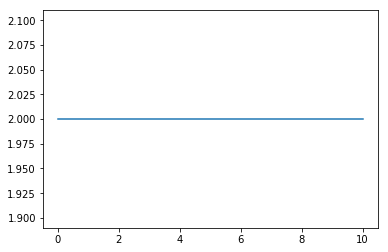

In [170]:
t_a = np.linspace(10/500,10,500)
pos=[]
vel=[]
acc=[]
for i in t_a:
    m.actuators[0].t=i
    pos.append(m.actuators[0].pos)
    vel.append(m.actuators[0].vel)
    acc.append(m.actuators[0].acc)
plt.plot(t_a,vel)
plt.show()

In [171]:
j,e,v,a,nzi,mapper_j,mapper_v, mapper_a = equations_assembler(m.topology)

In [172]:
t_a = np.linspace(10/500,10,500)
qs,qv,qa = kds(m.topology,m.actuators,t_a)


Running System Kinematic Analysis:
Recalculating Jacobian


In [173]:
def f(i):
    plt.figure(figsize=(8,8))
    plt.plot(t_a[0:i],qs['rbs_crank.x'][0:i])
    #plt.plot(t_a[0:i],qv['rbs_crank.z'][0:i])
    #plt.plot(qs['rbs_crank.z'][0:i],qs['rbs_slider.x'][0:i])
    #plt.xlim(0,10)
    #plt.xlim(-40,40)
    #plt.ylim(75,240)
    plt.grid()
    plt.show()
widgets.interact(f,i=widgets.IntSlider(value=1,max=500,min=1))


interactive(children=(IntSlider(value=1, description='i', max=500, min=1), Output()), _dom_classes=('widget-in…

<function __main__.f>

In [15]:
def f(i):
    plt.figure(figsize=(8,8))
    plt.plot(t_a[0:i],qa['rbs_link.z'][0:i])
    plt.plot(t_a[0:i],qa['rbs_link.x'][0:i])
    plt.xlim(0,10)
    plt.grid()
    plt.show()
widgets.interact(f,i=(0,500))


interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [50]:
def f(i):
    plt.figure(figsize=(8,8))
    plt.plot(qs['rbs_link.x'][0:i],qs['rbs_link.z'][0:i])
    plt.xlim(-1500,1500)
    plt.ylim(-1500,1500)
    plt.grid()
    plt.show()
widgets.interact(f,i=(0,500))

interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [36]:
def f(i):
    plt.plot(t_a[0:i],qv['rbs_link.z'][0:i])
    plt.plot(t_a[0:i],qv['rbs_link.x'][0:i])
    plt.show()
widgets.interact(f,i=(0,500))

interactive(children=(IntSlider(value=250, description='i', max=500), Output()), _dom_classes=('widget-interac…

<function __main__.f>

In [181]:
qt = q0.values
%timeit jacobian_evaluator(j,nzi,mapper_j,qt)

TypeError: sparse matrix length is ambiguous; use getnnz() or shape[0]